In [2]:
import numpy as np
import pandas as pd
from functions import preprocess, activations, losses

In [19]:
fake_real, fake_pred = np.random.randint(0,100,2), np.random.randint(0,100,2) 
print(fake_real)
print(fake_pred)
losses.MSLE(fake_real, fake_pred)

[11 53]
[44 18]


1.419056449176256

In [5]:
((82-43)+(96-60)) /2

37.5

In [2]:
df = pd.read_csv('datasets/Train.csv')
df = df.dropna(axis=1).drop(['ID','country','population'],axis=1)

In [3]:
df2 = preprocess.min_max(preprocess.mean_normalization(df))

In [4]:
features = df2.loc[:,'Q1':'Q25']
target = df2['target']

X = features.values.T
Y = target.values

In [5]:
split = 0.8
size = X.shape[1]

X_test = X[:,int(size*split):]
X = X[:,:int(size*split)]

Y_test = Y[int(size*split):]
Y = Y[:int(size*split)]

In [6]:
X.shape, X_test.shape

((16, 83893), (16, 20974))

# Multi-layered Model
<img src='images/net.png' width='500px'>

# Modelling

In [7]:
def initiate_model(X, Y, learning_rate=0.001, hidden_layers=[10,10]):
    
    n_features, n_samples = X.shape
    layers = [n_features, *hidden_layers, 1]
    
    model = {'learning_rate':learning_rate, 'layers':layers, 'W':{}, 'B':{}}

    for layer, nodes in enumerate(layers):
        
        #First layer doesn't have weights & biases
        if layer == 0:
            pass 
        else:
            model['W'][layer] = np.random.randn(layers[layer], layers[layer-1]) / np.sqrt(layers[layer-1])
            model['B'][layer] = np.zeros((layers[layer], 1))
            
    model['Z'], model['A'] = {}, {0:X}

    model['dLoss'] = {}
    model['dLoss']['Z'], model['dLoss']['A'], model['dLoss']['W'], model['dLoss']['B'],= {}, {}, {}, {}
            
    return model

In [8]:
#Calculating predictions with current weights and biases
def forwarding(model):
    
    layers = model['layers']
    
    for layer, nodes in enumerate(layers):
    
        #skip input layer because it doesn't need calculations
        if layer == 0:
            pass 
        
        else:
            
            # Mulitply output of last layer by weights (of current layer) & adding bias
            model['Z'][layer] = (model['W'][layer]).dot(model['A'][layer-1]) + model['B'][layer]
            
            #Transforming value using activation function to 0 to 1 range (Last A is the y_pred)
            model['A'][layer] = activations.sigmoid(model['Z'][layer])
    
    return model

In [9]:
def backwarding(model):
    
    layers = model['layers']
    learning_rate = model['learning_rate']
    
    #Derivative of loss funtcion
    dLoss_Y_pred = model['dLoss']['A'][len(layers)-1] = (-Y / (y_pred+0.00001)) - ((1-Y)/(1-y_pred + 0.00001))
    
    #Start at last layer and update all weights and biases backwards
    for layer in range(len(layers)-1,0,-1):
        
        #Prevent muliplication overflow
        model['dLoss']['Z'][layer] = np.where(model['dLoss']['A'][layer] > 1000, 1000, model['dLoss']['A'][layer]) * np.where(activations.dSigmoid(model['A'][layer]) > 1000, 1000, activations.dSigmoid(model['Z'][layer])) #Should be Z
        model['dLoss']['A'][layer-1] = np.dot(model['W'][layer].T, model['dLoss']['Z'][layer])
        model['dLoss']['W'][layer] =  1 / model['A'][layer-1].shape[1] * np.dot(model['dLoss']['Z'][layer], model['A'][layer-1].T)
        model['dLoss']['B'][layer] =  1 / model['A'][layer-1].shape[1] * np.dot(model['dLoss']['Z'][layer], np.ones([model['dLoss']['Z'][layer].shape[1], 1]))
        
        model['W'][layer] -= learning_rate * model['dLoss']['W'][layer]
        model['B'][layer] -= learning_rate * model['dLoss']['B'][layer]
        
    return model

In [10]:
last = 1
logger = 1
longer = []
loss = 100
model = initiate_model(X,Y,hidden_layers=[16,16],learning_rate=0.001)

for _ in range(100):
    last = loss
    model = forwarding(model)
    y_pred = model['A'][len(model['A'])-1]  
    model = backwarding(model)
    loss = losses.binary_crossentropy(model['A'][len(model['A'])-1], Y)
    longer.append(loss)
    print(loss)
    if last - loss < 0.0005:
        break
    

11.57492288140693
11.572880939339878
11.570837795570961
11.56879345122098
11.566747907412008
11.564701165264719
11.56265322590818
11.560604090468132
11.558553760075114
11.556502235862906
11.554449518964569
11.55239561051891
11.550340511664563
11.548284223541366
11.54622674729458
11.544168084071769
11.542108235017329
11.540047201284237
11.537984984023728
11.535921584391335
11.533857003543922
11.531791242639738
11.52972430283889
11.52765618530683
11.525586891208317
11.523516421709878
11.521444777983154
11.519371961198395
11.517297972528695
11.515222813153006
11.513146484245754
11.511068986990686
11.508990322567778
11.506910492162675
11.504829496959033
11.502747338148373
11.500664016920172
11.498579534467373
11.49649389198274
11.494407090665252
11.492319131711978
11.490230016322927
11.488139745701453
11.486048321053753
11.48395574358447
11.481862014501868
11.479767135016836
11.477671106343207
11.475573929693681
11.473475606285074
11.471376137335561
11.46927552406532
11.467173767696195
11.

<AxesSubplot:>

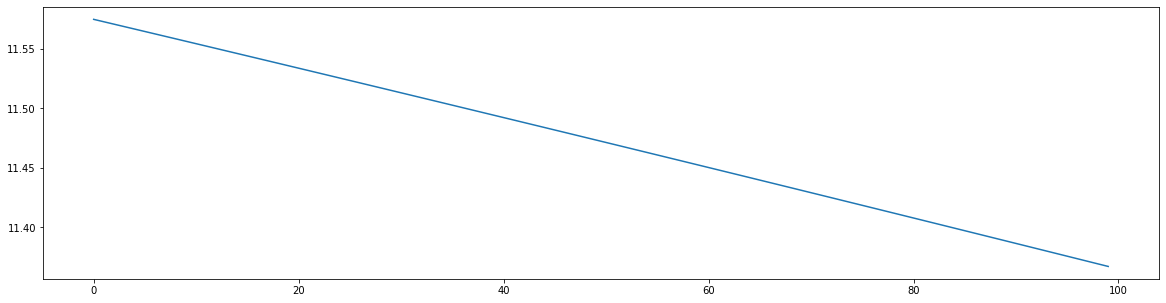

In [11]:
pd.Series(longer).plot(figsize=(20,5))

# Evaluating

In [12]:
model['A'][0] = X_test
model = forwarding(model)
predictions = model['A'][3]
print(round((np.where(predictions > 0.5, 1, 0) == Y_test).mean(),4))

0.5814
